# Fitlib Demonstration

This notebook demonstrates the functionality of `fitlib`, a flexible Python library for fitting data using probability density functions. 

---

## Example 1

As a first introduction, we will:

1. Generate synthetic data.
2. Use `Fitter` to create a histogram of the data.
3. Fit a Gaussian distribution to the data.
4. Summarize the fitting results.
5. Visualize the histogram and the fit.

---

### Step 1: Import Necessary Modules
Start by importing the necessary modules, including `fitlib`.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitlib

In [2]:
%load_ext autoreload
%autoreload 2

---

## Step 2: Generate Synthetic Data
For this demonstration, we generate synthetic data sampled from a Gaussian distribution.

In [3]:
mean, sigma = 0, 1
data = np.random.normal(mean, sigma, 1000)

---

## Step 3: Create a Fitter Instance
Create a `Fitter` instance to manage the data and the fitting process. We will perform a binned $\chi^2$ minimization fit, so we generated a binned fitter with 30 bins.



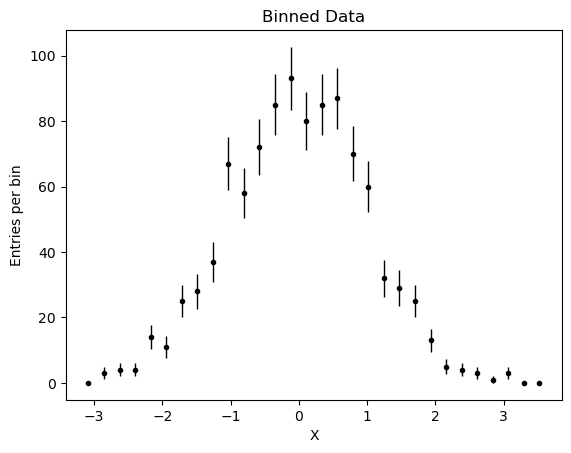

In [4]:
fit = fitlib.Fitter.binned(data,30)
fit.plot_data()
plt.title("Binned Data")
plt.xlabel("X")
plt.ylabel("Entries per bin")
plt.show()

---

## Step 4: Define a PDF
Define a Gaussian PDF and assign it to the fitter. Limits are not necessary for this fit, but are added for demonstration.

In [5]:
fit.pdf = [
    fitlib.Normal(
        n=(100, 500, 1500), # (lower limit, starting value, upper limit)
        mu=(-1, 1), # (lower limit, upper limit)
        sigma=(0.5, np.inf)
    )
]

---

## Step 5: Perform the Fit
Use the `chi2` method to perform a chi-squared minimization fit.

In [6]:
# returns the iminuit minimizer object
fit.chi2()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 20.67                      │              Nfcn = 98               │
│ EDM = 2.59e-07 (Goal: 0.0002)    │            time = 2.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    979    │    31     │            │            │   100   │  1500   │       │
│ 1 │ x1   │  -0.022   │   0.032   │            │            │   -1    │    1    │       │
│ 2 │ x2   │   0.989   │   0.024   │            │            │   0.5   │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────┐
│    │       x0       x1       x2 │
├────┼────────────────────────────┤
│ x0 │      982  -0.0047  12.1e-3 │
│ x1 │  -0.0047  0.00104  -0.1e-3 │
│ x2 │  12.1e-3  -0.1e-3 0.000581 │
└────┴────────────────────────────┘

We may view the results in this table too, where names are taken from the pdf function

In [7]:
fit.summary()

Component 1
| Parameter   |       Value |      Error |
|-------------|-------------|------------|
| n           | 979.278     | 31.3178    |
| mu          |  -0.0224194 |  0.0322049 |
| sigma       |   0.988814  |  0.0240999 |



---

## Step 6: Visualize the Fit
Overlay the fitted PDF on the binned data.

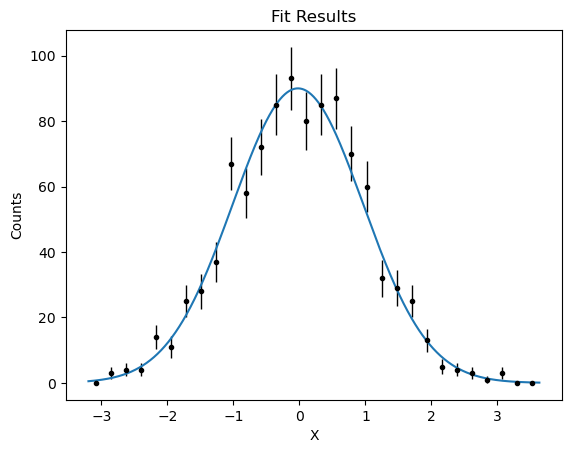

In [8]:
# Plot the fit alongside the data
fit.plot_data()
fit.plot_fit()
plt.title("Fit Results")
plt.xlabel("X")
plt.ylabel("Counts")
plt.show()

## Example 2

This example will showcase more complex methods. Lets say we have two signals and noise. The signal to noise ratio is around 2 to 5. However, we know that the peaks of the signals are apart by 50 units based on theory.

---

First we generate the data:

In [15]:
data2_noise = np.random.uniform(0,100,size=5000)
data2_signal1 = np.random.normal(30, 15, size=1000)
data2_signal2 = np.random.normal(80, 15, size=1000)

In [16]:
data2 = np.concatenate([data2_noise, data2_signal1, data2_signal2])

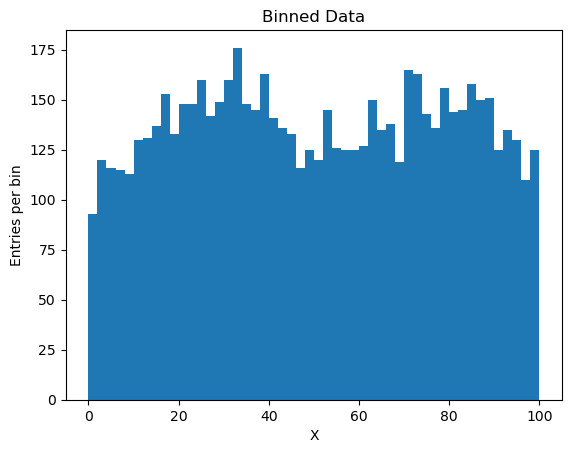

In [17]:
plt.title("Binned Data")
plt.xlabel("X")
plt.ylabel("Entries per bin")
plt.hist(data2, bins=50, range=(0,100))
plt.show()

### Can you see the peaks?

It's slight for sure. Lets see if the fitter can determine the distribution accurately. We use unbinned maximum likelihood estimation for this example.

In [18]:
fit2 = fitlib.Fitter(data2, (0,100))

To do MLE, we need to make sure our pdf adds up to 1, so I create two weight parameters. 

In [19]:
fit2.w1 = fitlib.f(0,1)
fit2.w2 = fitlib.f(0,1)
fit2.mu1 = fitlib.f(0,100)
fit2.mu_diff = fitlib.f(50) # Remember, we know the possible range of differences for mu2

In [20]:
fit2.pdf = [
    fitlib.Fit_function(lambda x, a: a/100, [fit2.w1]),
    fitlib.Normal(n=fit2.w2*(1-fit2.w1), mu=fit2.mu1),
    # just adding 50 would work too
    fitlib.Normal(n=1-(fit2.w2*(1-fit2.w1) + fit2.w1), mu=fit2.mu1+fit2.mu_diff) # we seperate the mean into mean 1 and a mean difference
    # this method of making sure weights add up to one is usually unnecessary. w1, w2, 1-w1-w2 works in most circumstances
]

In [21]:
fit2.MLE()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.329e+04                  │              Nfcn = 334              │
│ EDM = 9.74e-06 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   0.897   │   0.018   │            │            │    0    │    1    │       │
│ 1 │ x1   │   0.57    │   0.05    │            │            │    0    │    1    │       │
│ 2 │ x2   │   29.4    │    1.2    │            │            │    0    │   100   │       │
│ 3 │ x3   │    9.0    │    1.1    │            │            │    0    │         │       │
│ 4 │ x4   │   50.0    │    0.5    │            │            │         │         │  yes  │
│ 5 │ x5   │    7.5    │    0.9    │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────────┐
│    │       x0       x1       x2       x3       x4       x5 │
├────┼───────────────────────────────────────────────────────┤
│ x0 │ 0.000318  0.08e-3  3.47e-3 -8.98e-3        0 -6.29e-3 │
│ x1 │  0.08e-3  0.00263   0.0140   0.0112   0.0000  -0.0143 │
│ x2 │  3.47e-3   0.0140     1.39      0.0      0.0     -0.5 │
│ x3 │ -8.98e-3   0.0112      0.0     1.18      0.0      0.1 │
│ x4 │        0   0.0000      0.0      0.0        0      0.0 │
│ x5 │ -6.29e-3  -0.0143     -0.5      0.1      0.0    0.854 │
└────┴───────────────────────────────────────────────────────┘

In [22]:
fit2.summary()

Component 1
| Parameter   |    Value |     Error |
|-------------|----------|-----------|
| a           | 0.897347 | 0.0178295 |

Component 2
| Parameter   |     Value |     Error |
|-------------|-----------|-----------|
| n[0]        |  0.573811 | 0.0511722 |
| n[1]        |  0.897347 | 0.0178295 |
| mu          | 29.4354   | 1.17701   |
| sigma       |  9.01598  | 1.08743   |

Component 3
| Parameter   |     Value |     Error |
|-------------|-----------|-----------|
| n[0]        |  0.573811 | 0.0511722 |
| n[1]        |  0.897347 | 0.0178295 |
| n[2]        |  0.897347 | 0.0178295 |
| mu[0]       | 29.4354   | 1.17701   |
| mu[1]       | 50        | 0.5       |
| sigma       |  7.48751  | 0.923945  |



The model attributes much of the signal to background, as a is 0.93 and not the true 0.7, but the peak positions are accurate.